# PyTorch tutorial 4 — training a Zernike estimator from AO data

Now that we can generate AO data, we can train a **larger model** to predict **many Zernike modes** (e.g. 50–200) from a WFS- or PSF-like input.

We will:
1. Define the **model family** (CNN encoder, shallow UNet, or Conv+MLP) for modal regression.
2. Choose a **target representation** (Zernike ordered vector, NCPA modes, or DM modal basis).
3. Train with a **multi-output regression loss** (typically `MSELoss`) and explain why it is still **a scalar**.
4. Add **metrics** beyond the loss: RMS phase error, per-mode MSE, and % energy on the first modes.
5. Compare **optimizers** (Adam vs AdamW) and **schedulers** (StepLR / Cosine) for faster convergence.
6. Save the **trained checkpoint** and run **inference** on new turbulence realizations.

By the end of this notebook you will have a **trained Zernike regressor** that takes AO-like data and outputs a vector of modal coefficients.


In [39]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

from Functions.mvm import MVM
from Functions.fourier_masks import genOTF_PWFS4
from Functions.vonkarman_model_newv3 import VonKarmanPhaseScreenGenerator 

In [40]:
N = 128  # Grid size
D = 3.0  # Telescope diameter in meters
size_pupils_pixels = 64  # Pupil size in pixels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
def pwfs_propagation(pupil_amp, pupil_phase, pyr_mask):
    u_pupil = pupil_amp * torch.exp(1j * pupil_phase)
    U_foc   = torch.fft.fft2(u_pupil)
    U_foc   = torch.fft.fftshift(U_foc, dim=(-2,-1))
    H_pyr   = pyr_mask[0,0]
    U_pyr   = U_foc * H_pyr
    U_pyr   = torch.fft.ifftshift(U_pyr, dim=(-2,-1))
    u_det   = torch.fft.ifft2(U_pyr)
    I_det   = u_det.real**2 + u_det.imag**2
    return I_det

def make_circular_pupil(N, D, device):
    y = torch.arange(N, device=device) - N//2
    x = torch.arange(N, device=device) - N//2
    Y, X = torch.meshgrid(y, x, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    return (R <= (D/2)).float()

Text(0.5, 1.0, 'PWFS response to piston aberration')

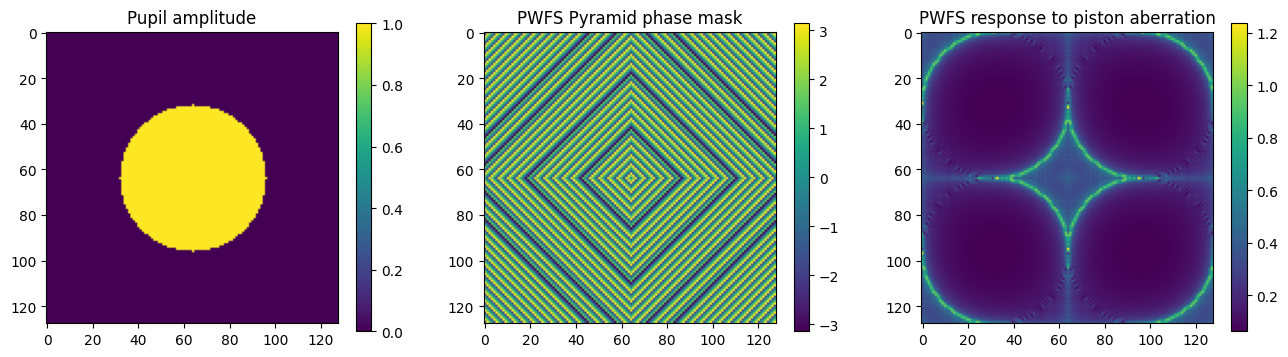

In [ ]:
N = 128  # Grid size
D = 3.0  # Telescope diameter in meters
size_pupils_pixels = 64  # Pupil size in pixels

pupil = make_circular_pupil(N, size_pupils_pixels, device=device)
pyr_mask = genOTF_PWFS4(N_fourier_points=N, N_points_aperture=size_pupils_pixels, separation=1.0, device=device)
phi = torch.zeros((1,1,N,N), device=device)

piston_pwfs = pwfs_propagation(pupil, phi, pyr_mask).clamp_min(0.0)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(pupil.squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Pupil amplitude")
plt.subplot(1,3,2)
plt.imshow(torch.angle(pyr_mask).squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("PWFS Pyramid phase mask")
plt.subplot(1,3,3)
plt.imshow(piston_pwfs.squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("PWFS response to piston aberration")

Text(0.5, 1.0, 'PWFS response to piston aberration')

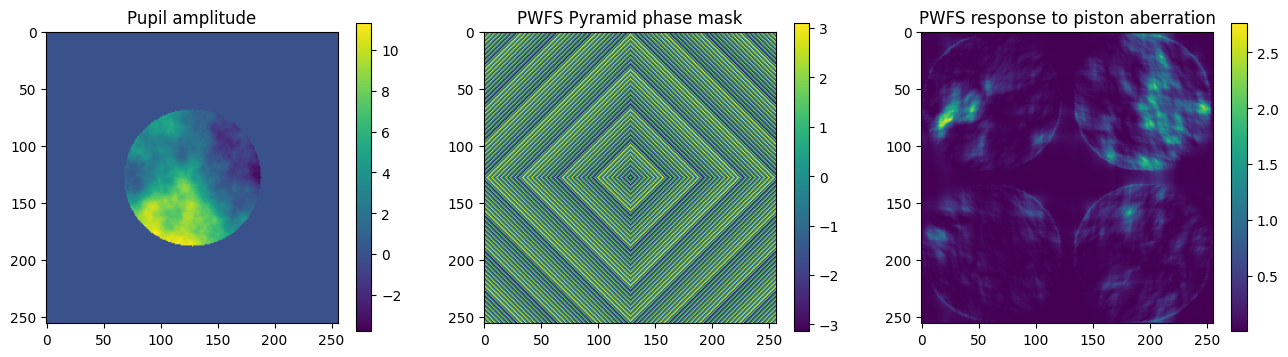

In [96]:
N = 256  # Grid size
D = 3.0  # Telescope diameter in meters
size_pupils_pixels = 120  # Pupil size in pixels

pupil = make_circular_pupil(N, size_pupils_pixels, device=device)
pyr_mask = genOTF_PWFS4(N_fourier_points=N, N_points_aperture=size_pupils_pixels, separation=1.1, device=device)

batch_size = 1
r0 = 0.1   # Fried parameter in meters
L0 = 20.0   # Outer scale in meters
l0 = 0.001  # Inner scale in meters

vk_rand = VonKarmanPhaseScreenGenerator(
    N=N, D_tel=D, r0=r0, L0=L0, l0=l0,
    pupil_mask=pupil, device=device, batch_size=batch_size
)

phase = vk_rand.generate_total_phase().detach()

phase_pwfs = pwfs_propagation(pupil, phase, pyr_mask).clamp_min(0.0)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(phase.squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Pupil amplitude")
plt.subplot(1,3,2)
plt.imshow(torch.angle(pyr_mask).squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("PWFS Pyramid phase mask")
plt.subplot(1,3,3)
plt.imshow(phase_pwfs.squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("PWFS response to piston aberration")

Text(0.5, 1.0, 'PWFS intensity (normalized)')

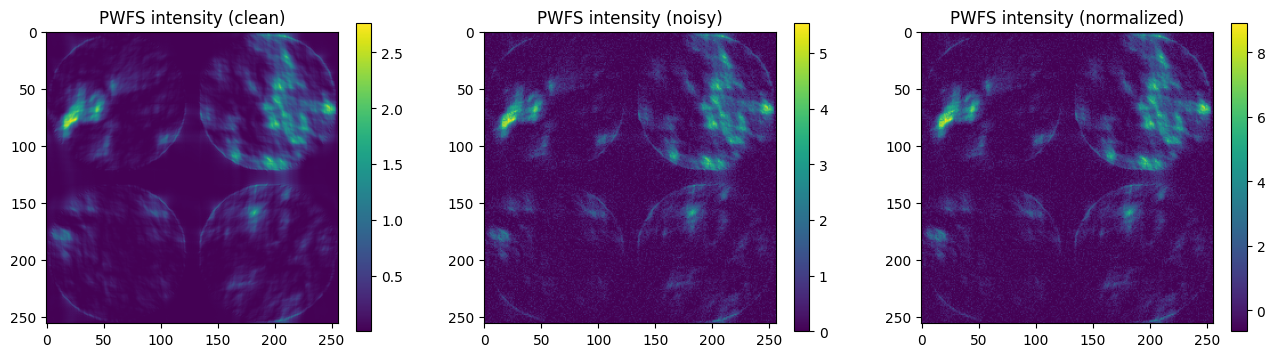

In [97]:
def add_noise(x, rn=2.0, photons=1e4, scale=1.0, use_poisson=True):
    y = x.real.float().clamp(min=0)*scale
    if use_poisson: y = torch.poisson((y*photons).clamp(min=0))/photons
    return (y + torch.randn_like(y)*rn).clamp_(min=0)

def normalize(x, norm='minmax'):
    if norm == 'minmax':
        x_min = x.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        x_max = x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
        return (x - x_min) / (x_max - x_min + 1e-10)
    elif norm == 'zscore':
        x_mean = x.mean(dim=(-1,-2), keepdim=True)
        x_std  = x.std(dim=(-1,-2), keepdim=True)
        return (x - x_mean) / (x_std + 1e-10)
    else:
        raise ValueError("Unsupported normalization method")

I_noisy = add_noise(phase_pwfs, rn=0.2, photons=10e3, scale=2.0, use_poisson=True)
I_norm = normalize(I_noisy, norm='zscore')

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(phase_pwfs.squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("PWFS intensity (clean)")
plt.subplot(1,3,2)
plt.imshow(I_noisy.squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("PWFS intensity (noisy)")
plt.subplot(1,3,3)
plt.imshow(I_norm.squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("PWFS intensity (normalized)")